## Problem Statement

We have been given a PDE:
$$
\dfrac{\partial C}{\partial t} + \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2 C}{\partial S^2} + rS\dfrac{\partial C}{\partial S} -rC = 0
$$
and boundary conditions:
$$
\begin{align*}
   &C(t, 0) = 0 &&\text{for all $t \geq 0$}\\
   &C(t, S) \to S - K &&\text{for all $t \geq 0$ as $S \to \infty$}\\
   &C(T, S) = \max\{S - K, 0\}
\end{align*}
$$

- Independent variables: $t, S$ (input)
- Dependent variables: $C$ (outputs)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as tgrad
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as si

In [3]:
K = 40              # Strike Price
r = 0.05            # Interest Rate
sigma = 0.25        # Annual volatility of asset
T = 1               # Time to maturity
S_range = [0, 500]  # Input ranges for asset price
t_range = [0, T]    # Input ranges for time
gs = lambda x: np.fmax(x - K, 0)  # Instrinsic value of call option

In [4]:
def black_scholes_call_div(X, K, r, sigma):
    T = X[:, 0]
    S = X[:, 1]

    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S/K) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    
    call = (S*si.norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r*T)*si.norm.cdf(d2, 0.0, 1.0))
    return call

First we define the samplers for datapoints to be used for the training process.
Uniform distribution is used to generate the data points.

In [5]:
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1))
    return X, y

def get_evp_data(n):
    X = np.concatenate([np.ones((n, 1)),
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)
    
    return X, y

def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))
    
    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = black_scholes_call_div(X2, K, r, sigma).reshape(-1, 1)
    # y2 = np.array([black_scholes_call_div(X, K, T, r, sigma) for (T, X) in X2]).reshape(-1, 1)
    # y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)
    
    return X1, y1, X2, y2

The resulting points plot looks like this.
Here, 1000 points are sampled for expirational / boundary values, and 5000 points are sampled for collocation.

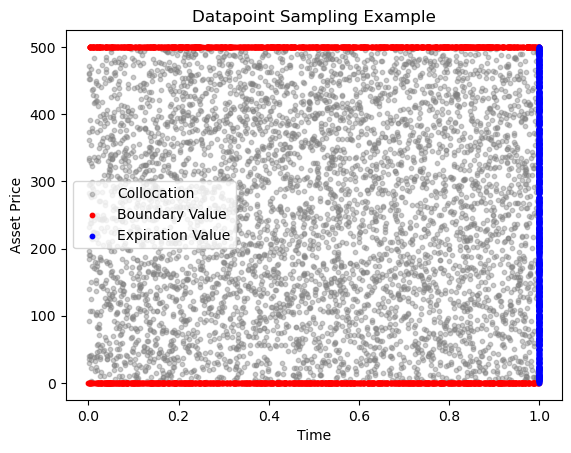

In [6]:
X1, _ = get_diff_data(5000)
X21, _, X22, _ = get_bvp_data(1000)
X3, _ = get_evp_data(1000)

plt.scatter(X1[:,0], X1[:,1], color='gray', s=10, alpha=0.4, label='Collocation')
plt.scatter(X21[:,0], X21[:,1], color='red', s=10, label='Boundary Value')
plt.scatter(X22[:,0], X22[:,1], color='red', s=10)
plt.scatter(X3[:,0], X3[:,1], color='blue', s=10, label='Expiration Value')

plt.xlabel('Time')
plt.ylabel('Asset Price')
plt.title('Datapoint Sampling Example')
plt.legend()

plt.show()

Now we implement the neural network.

In [24]:
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(PINN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.hidden_layer1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.hidden_layer2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer3 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer4 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer5 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # self.activation = torch.sigmoid
        self.activation = torch.relu

        # torch.nn.init.zeros_(self.hidden_layer1.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer2.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer3.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer4.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer5.weight.data)
        # torch.nn.init.zeros_(self.output_layer.weight.data)
    
        # torch.nn.init.kaiming_normal_(self.hidden_layer1.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer2.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer3.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer4.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer5.weight.data)
        # torch.nn.init.kaiming_normal_(self.output_layer.weight.data)

        torch.nn.init.xavier_normal_(self.hidden_layer1.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer2.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer3.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer4.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer5.weight.data)
        torch.nn.init.xavier_normal_(self.output_layer.weight.data)

    def forward(self, x):
        inputs = x
        layer1_out = self.activation(self.hidden_layer1(inputs))
        layer2_out = self.activation(self.hidden_layer2(layer1_out))
        layer3_out = self.activation(self.hidden_layer3(layer2_out))
        layer4_out = self.activation(self.hidden_layer4(layer3_out))
        layer5_out = self.activation(self.hidden_layer5(layer4_out))
        out = self.output_layer(layer5_out)
        return out

We setup the model architecture with following hyperparameters, and start training.

In [25]:
model = PINN(2, 128, 1)
model.cuda()

n_epochs = 100000
samples = {"pde": 5000, "bvp":5000, "evp":5000}
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [26]:
loss_hist = []

for epoch in range(n_epochs):
    # Loss based on PDE
    X1, y1 = get_diff_data(samples['pde'])
    X1 = torch.from_numpy(X1).float().requires_grad_().cuda()
    y1 = torch.from_numpy(y1).float().cuda()
    
    y1_hat = model(X1)
    
    grads_1 = tgrad.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape).cuda(), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dV_dt, dV_dS = grads_1[:, 0].view(-1, 1), grads_1[:, 1].view(-1, 1)
    grads_2 = tgrad.grad(dV_dS, X1, grad_outputs=torch.ones(dV_dS.shape).cuda(), create_graph=True, only_inputs=True)[0]
    d2V_dS2 = grads_2[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    pde_loss = criterion(-dV_dt, 0.5*((sigma*S1)**2)*d2V_dS2 + r*S1*dV_dS - r*y1_hat)
    
    # Loss based on boundary conditions
    X21, y21, X22, y22 = get_bvp_data(samples['bvp'])
    
    X21 = torch.from_numpy(X21).float().cuda()
    y21 = torch.from_numpy(y21).float().cuda()
    
    X22 = torch.from_numpy(X22).float().cuda()
    y22 = torch.from_numpy(y22).float().cuda()
    
    y21_hat = model(X21)
    bvp1_loss = criterion(y21, y21_hat)
    
    y22_hat = model(X22)
    bvp2_loss = criterion(y22, y22_hat)
    
    # Loss based on expirational conditions
    X3, y3 = get_evp_data(samples['evp'])
    
    X3 = torch.from_numpy(X3).float().cuda()
    y3 = torch.from_numpy(y3).float().cuda()
    
    y3_hat = model(X3)
    evp_loss = criterion(y3, y3_hat)
    
    # Combining the loss functions
    loss = pde_loss + bvp1_loss + bvp2_loss + evp_loss
    
    # Backpropagation and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_hist.append(loss.item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BVP1 Loss: {bvp1_loss.item():.5f}, BVP2 Loss: {bvp2_loss.item():.5f}, EVP Loss: {evp_loss.item():.5f},')
    

0/100000 PDE Loss: 0.00218, BVP1 Loss: 0.02782, BVP2 Loss: 208457.54688, EVP Loss: 63099.53125,
500/100000 PDE Loss: 0.89805, BVP1 Loss: 0.00011, BVP2 Loss: 4.98088, EVP Loss: 78.85794,
1000/100000 PDE Loss: 1.01909, BVP1 Loss: 0.00000, BVP2 Loss: 0.66288, EVP Loss: 0.21258,
1500/100000 PDE Loss: 0.11028, BVP1 Loss: 0.00000, BVP2 Loss: 0.55078, EVP Loss: 0.07872,
2000/100000 PDE Loss: 0.05604, BVP1 Loss: 0.00000, BVP2 Loss: 0.59239, EVP Loss: 0.05684,
2500/100000 PDE Loss: 0.03107, BVP1 Loss: 0.00007, BVP2 Loss: 1.77735, EVP Loss: 0.23817,
3000/100000 PDE Loss: 0.06299, BVP1 Loss: 0.00000, BVP2 Loss: 0.47316, EVP Loss: 0.19365,
3500/100000 PDE Loss: 0.06697, BVP1 Loss: 0.00000, BVP2 Loss: 0.45167, EVP Loss: 0.10189,
4000/100000 PDE Loss: 0.07078, BVP1 Loss: 0.00000, BVP2 Loss: 0.58233, EVP Loss: 0.04190,
4500/100000 PDE Loss: 0.07238, BVP1 Loss: 0.00000, BVP2 Loss: 0.50995, EVP Loss: 0.31690,
5000/100000 PDE Loss: 0.04189, BVP1 Loss: 0.00000, BVP2 Loss: 0.48812, EVP Loss: 0.08388,
5500

Finally, we plot our results to check the performance of the model.

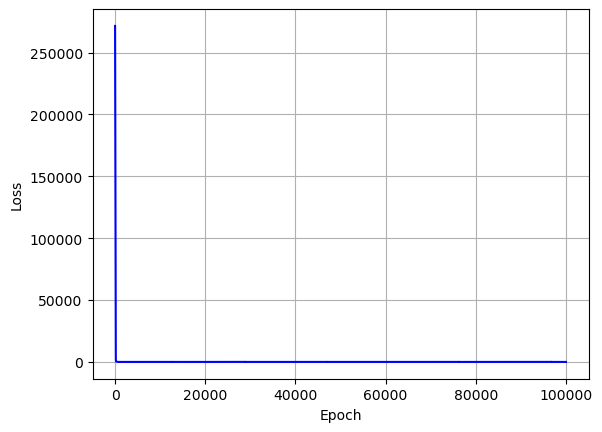

In [27]:
x_len = np.arange(len(loss_hist))
plt.plot(x_len, loss_hist, c='blue', label="Train-set Loss")
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

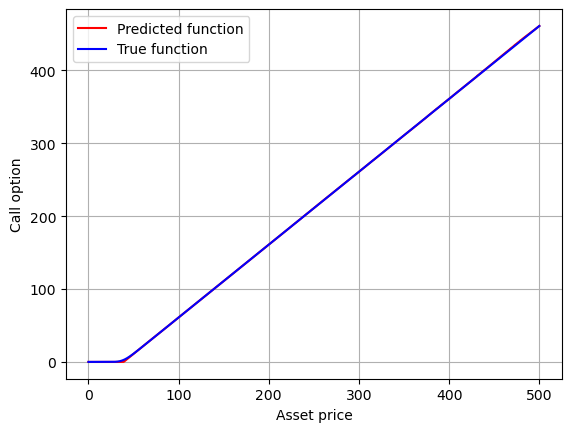

In [28]:
# This function resolves redundant legend issues when using matplotlib library.
# Retrieved from https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

np.seterr(divide = 'ignore')
fig, ax = plt.subplots()

X_cmp = np.concatenate([0.5*np.ones((1000, 1)),
                        np.linspace(0, 500, num=1000).reshape(-1, 1)], axis=1)
Y_pred = model(torch.from_numpy(X_cmp).float().requires_grad_().cuda()).cpu().detach()
Y_true = black_scholes_call_div(X_cmp, K, r, sigma)

X_cmp = np.linspace(0, 500, num=1000)

ax.plot(X_cmp, Y_pred, c='red', label="Predicted function")
ax.plot(X_cmp, Y_true, c='blue', label="True function")

legend_without_duplicate_labels(ax)

plt.grid()
plt.xlabel('Asset price')
plt.ylabel('Call option')

plt.show()

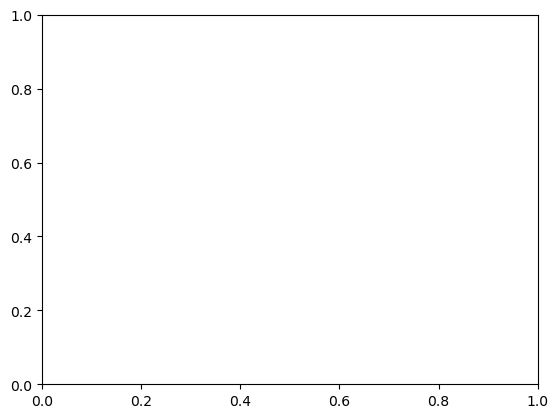

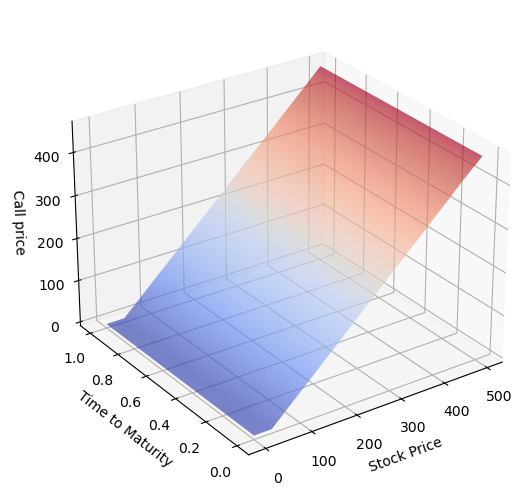

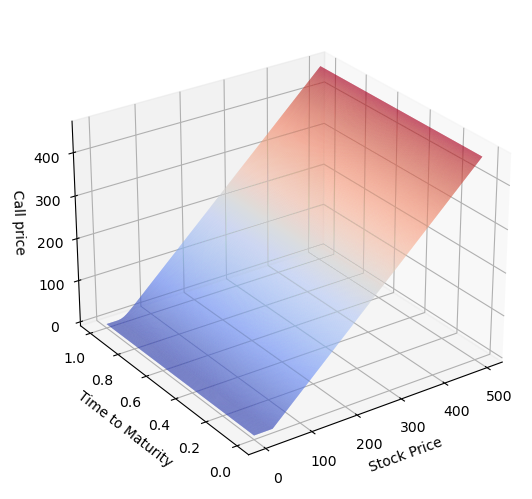

In [29]:
# 3D plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

fig, ax = plt.subplots()
Y_pred_arr, Y_true_arr = [], []

for t in np.linspace(0, 1, num=1000):
    X_cmp = np.concatenate([t*np.ones((1000, 1)),
                            np.linspace(0, 500, num=1000).reshape(-1, 1)], axis=1)
    Y_pred = model(torch.from_numpy(X_cmp).float().requires_grad_().cuda()).cpu().detach()
    Y_true = black_scholes_call_div(X_cmp, K, r, sigma)
    Y_pred_arr.append(np.array(Y_pred))
    Y_true_arr.append(np.array(Y_true))

X, Y = np.meshgrid(np.linspace(0, 500, num=1000), np.linspace(0, 1, num=1000))

Y_pred_arr = np.array(Y_pred_arr).reshape(1000, 1000)
Y_true_arr = np.array(Y_true_arr).reshape(1000, 1000)

figcp = plt.figure()
ax = Axes3D(figcp)
ax.plot_surface(X, Y, Y_pred_arr, rstride=1, cstride=1, cmap=cm.coolwarm, shade='interp')
ax.view_init(27,-125)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call price')

figct = plt.figure()
ax = Axes3D(figct)
ax.plot_surface(X, Y, Y_true_arr, rstride=1, cstride=1, cmap=cm.coolwarm, shade='interp')
ax.view_init(27,-125)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call price')

plt.show()